In [1]:
from influxdb_client_3 import InfluxDBClient3
import pyarrow as pa
import matplotlib.pyplot as plt
import pandas as pd

# Connect to InfluxDB 3
client = InfluxDBClient3(
    host="http://3.98.181.12:9000",
    token="apiv3_wfr_admin_token_change_in_production",
    database="WFR25"
)

In [2]:
# Check InfluxDB connection
try:
    # Simple query to test connection
    test_query = client.query("SELECT 1 as test")
    print("Connection to InfluxDB successful!")
    print("Test query result:", test_query)
except Exception as e:
    print(f"Connection failed: {e}")

Connection to InfluxDB successful!
Test query result: pyarrow.Table
test: int64 not null
----
test: [[1]]


In [3]:
# Query unique sensors
unique_sensors = client.query("""
SELECT DISTINCT "signalName" FROM "iox"."WFR25" WHERE time >= '2025-06-19T00:00:00Z'
""")
print("Unique sensors:", unique_sensors)

Unique sensors: pyarrow.Table
signalName: string
----
signalName: [["A1","A10","A11","A12","A13",...,"INV_Diag_Sin_Used","INV_Diag_Vd_Cmd","INV_Diag_Vdc","INV_Diag_Vq_Cmd","INV_Diag_Vqs_Cmd"]]


In [ ]:
# Query to find the highest historical value of signal 'INV_DC_Bus_Voltage'
max_value_table = client.query("""
    SELECT MAX("sensorReading") as max_value
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Voltage'
""")

print("Max value query result:")
print(max_value_table)

Max value query result:
pyarrow.Table
max_value: double
----
max_value: [[860.9000000000001]]


860V?? That's a little crazy. Let's take a look at 99.9th percentile.

In [5]:
# Query to find the 99.9th percentile of signal 'INV_DC_Bus_Voltage'
percentile_999_table = client.query("""
    SELECT APPROX_PERCENTILE_CONT("sensorReading", 0.999) as percentile_999
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Voltage'
""")

print("99.9th percentile query result:")
print(percentile_999_table)

99.9th percentile query result:
pyarrow.Table
percentile_999: double
----
percentile_999: [[],[406.73718032787303]]


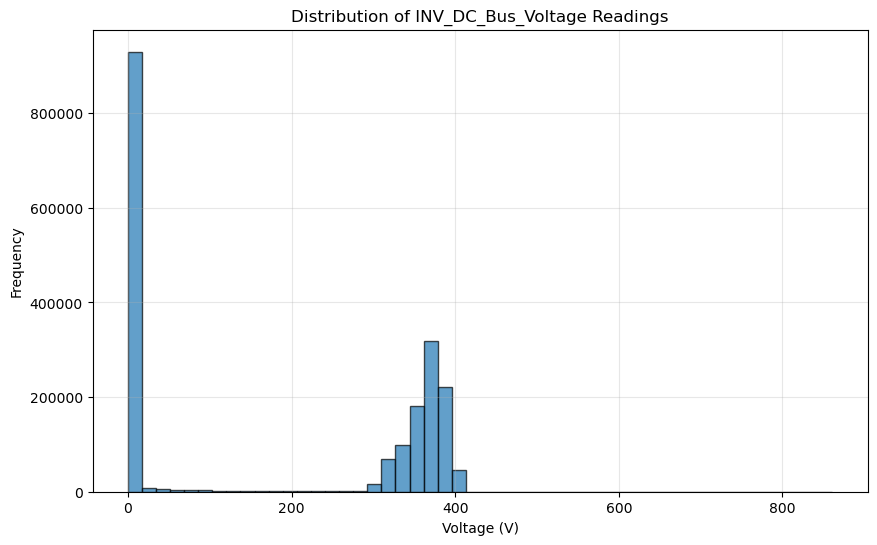

In [6]:
# Query all voltage readings for histogram
voltage_histogram_data = client.query("""
    SELECT "sensorReading"
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Voltage'
""")

# Convert to pandas for plotting
voltage_df = voltage_histogram_data.to_pandas()

# Plot histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(voltage_df['sensorReading'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of INV_DC_Bus_Voltage Readings')
plt.xlabel('Voltage (V)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Query to get the latest 10 entries from WFR25
latest_entries = client.query("""
    SELECT time, "sensorReading", "signalName"
    FROM "iox"."WFR25"
    ORDER BY time DESC
    LIMIT 10
""")

print("Latest 10 entries:")
print(latest_entries)

Latest 10 entries:
pyarrow.Table
time: timestamp[ns] not null
sensorReading: double
signalName: string
----
time: [[2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.284000000,2025-09-30 02:09:02.284000000,2025-09-30 02:09:02.284000000]]
sensorReading: [[0,0,0,0,0,0,0,0,0,0]]
signalName: [["VCU_INV_Direction_Command","VCU_INV_Inverter_Enable","VCU_INV_Torque_Limit_Command","VCU_INV_Torque_Command","VCU_INV_Speed_Command","VCU_INV_Speed_Mode_Enable","VCU_INV_Inverter_Discharge","VCU_INV_Direction_Command","VCU_INV_Speed_Mode_Enable","VCU_INV_Speed_Command"]]


In [8]:
# Query to list available tables in the database
tables = client.query("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'iox'
""")

print("Available tables in iox schema:")
print(tables)

Available tables in iox schema:
pyarrow.Table
table_name: string not null
----
table_name: [["WFR25"]]


In [9]:
# Query to list all tables in the database
all_tables = client.query("""
    SELECT table_schema, table_name
    FROM information_schema.tables
""")

print("All tables:")
print(all_tables)

All tables:
pyarrow.Table
table_schema: string not null
table_name: string not null
----
table_schema: [["iox","system","system","system","system",...,"information_schema","information_schema","information_schema","information_schema","information_schema"]]
table_name: [["WFR25","distinct_caches","influxdb_schema","last_caches","parquet_files",...,"columns","df_settings","schemata","routines","parameters"]]


In [10]:
# Check the schema of the WFR25 table
schema_check = client.query("""
    SELECT *
    FROM "iox"."WFR25"
    LIMIT 1
""")

print("Table schema:")
print(schema_check.schema)
print("Sample data:")
print(schema_check)

Table schema:
canId: string
  -- field metadata --
  iox::column::type: 'iox::column_type::tag'
messageName: string
  -- field metadata --
  iox::column::type: 'iox::column_type::tag'
sensorReading: double
  -- field metadata --
  iox::column::type: 'iox::column_type::field::float'
signalName: string
  -- field metadata --
  iox::column::type: 'iox::column_type::tag'
time: timestamp[ns] not null
  -- field metadata --
  iox::column::type: 'iox::column_type::timestamp'
Sample data:
pyarrow.Table
canId: string
messageName: string
sensorReading: double
signalName: string
time: timestamp[ns] not null
----
canId: [["2014"]]
messageName: [["VCU_Front_Sensors_1"]]
sensorReading: [[0.52]]
signalName: [["A1"]]
time: [[2025-05-29 18:30:00.025000192]]


In [11]:
# Query voltage
voltage_data = client.query("""
    SELECT time, "sensorReading"
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Voltage'
    ORDER BY time
""")

# Query current
current_data = client.query("""
    SELECT time, "sensorReading"
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Current'
    ORDER BY time
""")

# Convert both to pandas
import pandas as pd

df_v = voltage_data.to_pandas().rename(columns={"sensorReading": "voltage"}).set_index("time")
df_c = current_data.to_pandas().rename(columns={"sensorReading": "current"}).set_index("time")

# Merge on time (inner join to align timestamps)
df = pd.merge_asof(df_v.sort_index(), df_c.sort_index(), 
                   left_index=True, right_index=True, 
                   direction="nearest", tolerance=pd.Timedelta("100ms"))

# Compute power
df["power"] = df["voltage"] * df["current"]

In [12]:
def analyze_sustained_power(df, window_seconds, min_points=20, metric='median'):
    """
    Analyze the highest sustained power over a rolling window.
    
    Args:
        df: DataFrame with 'power' column and datetime index
        window_seconds: Size of the rolling window in seconds
        min_points: Minimum number of points required in the window
        metric: 'mean' or 'median' for aggregation
    
    Returns:
        max_median: Maximum aggregated power in the window (or None if no valid windows)
        start_time: Start of the period
        end_time: End of the period
        count: Number of values in the window
    """
    if metric == 'mean':
        rolling_agg = df["power"].rolling(f"{window_seconds}s").mean()
    elif metric == 'median':
        rolling_agg = df["power"].rolling(f"{window_seconds}s").median()
    else:
        raise ValueError("Metric must be 'mean' or 'median'")
    
    rolling_count = df["power"].rolling(f"{window_seconds}s").count()
    
    # Filter to windows with at least min_points
    valid_windows = rolling_count >= min_points
    
    if not valid_windows.any():
        print(f"No windows with at least {min_points} points found for {window_seconds}s.")
        return None, None, None, None
    
    # Find max among valid windows
    max_median = rolling_agg[valid_windows].max()
    max_time = rolling_agg[valid_windows].idxmax()
    
    start_time = max_time - pd.Timedelta(seconds=window_seconds)
    end_time = max_time
    
    count = rolling_count.loc[max_time]
    
    return max_median, start_time, end_time, count

# Example usage with 4 seconds, using median
max_median, start_time, end_time, count = analyze_sustained_power(df, 2, metric='median')

if max_median is not None:
    print(f"Highest sustained 2s median power: {max_median:.2f} W")
    print(f"Number of values in the 2s window: {count}")
    print(f"Period start: {start_time}")
    print(f"Period end: {end_time}")

# Compare with median
max_median_5s, _, _, _ = analyze_sustained_power(df, 5, metric='median')
if max_median_5s is not None:
    print(f"\nFor comparison, highest sustained 5s median: {max_median_5s:.2f} W")

Highest sustained 2s median power: 52773.12 W
Number of values in the 2s window: 95.0
Period start: 2025-06-15 16:19:11.656000
Period end: 2025-06-15 16:19:13.656000

For comparison, highest sustained 5s median: 34862.67 W


Period start: 2025-06-15 16:19:11.656000
Period end: 2025-06-15 16:19:13.656000
Data points in period: 95
Sample data:
                               voltage  current     power
time                                                     
2025-06-15 16:19:11.672000000    377.8     42.8  16169.84
2025-06-15 16:19:11.693000192    375.4     49.2  18469.68
2025-06-15 16:19:11.717999872    375.7     49.9  18747.43
2025-06-15 16:19:11.734999808    375.5     50.1  18812.55
2025-06-15 16:19:11.756000000    374.8     53.0  19864.40


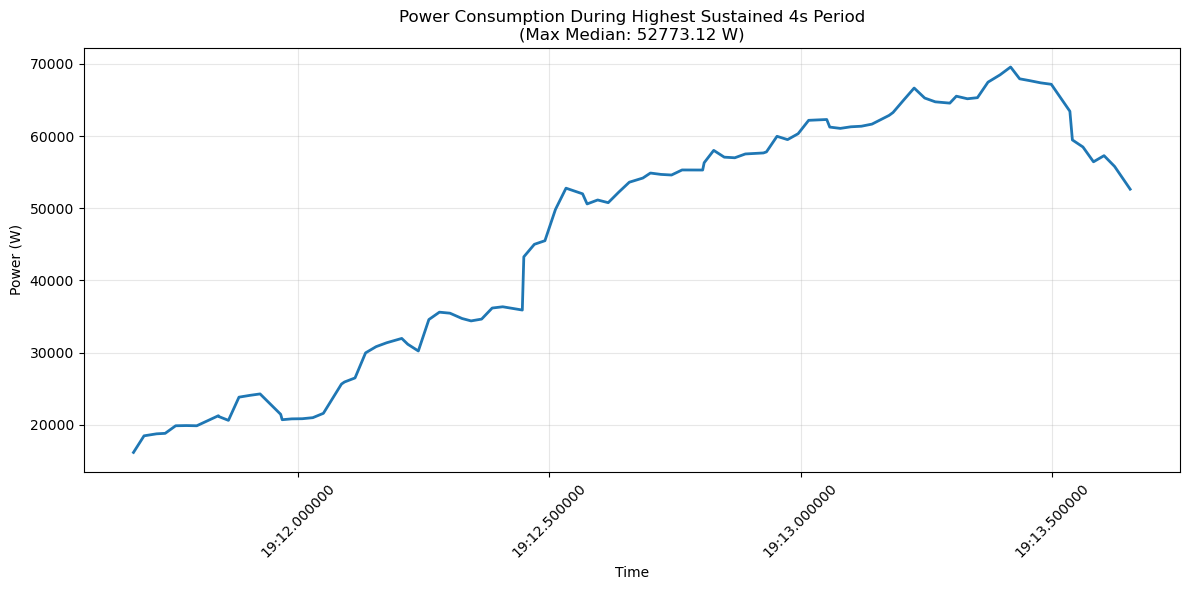

In [13]:
# Filter the dataframe to the 5-second period of highest sustained power
period_df = df.loc[start_time:end_time]

print(f"Period start: {start_time}")
print(f"Period end: {end_time}")
print(f"Data points in period: {len(period_df)}")
print("Sample data:")
print(period_df.head())

# Plot the power over time for this period
plt.figure(figsize=(12, 6))
plt.plot(period_df.index, period_df['power'], linewidth=2)
plt.title(f'Power Consumption During Highest Sustained 4s Period\n(Max Median: {max_median:.2f} W)')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()